# 트렌드 기반 컬러 매칭 프로젝트 개요
- 전신사진이나 상반신 사진을 통해 트렌드에 따른 상하의 색상 조합을 비교, 예측 받을 수 있습니다.
<Br>
<br>


## 1. YOLOv5를 활용한 물체 감지
- AI 허브에서 연도별 남성 패션 데이터 수집 (화보, 스냅샷 등)
- Roboflow 플랫폼을 활용하여 2019년 데이터에 대한 좌표 라벨링 설정
- YOLO 모델을 학습시켜 이미지 데이터에서 상의와 하의를 자동으로 검출
<br>


## 2. Kmeans 클러스터링을 활용한 색상 검출
- Roboflow 플랫폼을 활용하여 2019년 데이터에 대한 좌표 라벨링 설정
- 이전 단계와 유사하게 이미지 데이터와 좌표를 불러오고, Kmeans 클러스터링을 활용하여 경계 좌표 내의 픽셀에서 색상 추출
- 각 데이터에 일괄 적용하여 학습 데이터프레임 생성
<br>

## 3. 2019년 트렌드 바지 색상 예측을 위한 상하의 색상 조합 분석 (KNN)
- 1, 2번에서 얻은 상하의 데이터로 상의에 따른 하의 RGB값을 학습
- 얻은 데이터프레임으로 KNN 알고리즘 학습
- 상의와 하의의 색상 조합을 통해 2019년 트렌드 바지 색상을 비교 및 예측






In [2]:
from PIL import Image
import joblib
import torch
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import HTML, display

# 정규화된 값을 원래의 RGB 형태로 변환하는 함수
def convert_to_original(data):
    return tuple(np.array(data) * 255.0)

def convert_to_numeric(data):
    # RGB 값들을 0에서 1 사이의 실수 값으로 정규화
    return np.array([np.array(rgb) / 255.0 for rgb in data])


def kmeans_find_major_color(image):
    pixels = np.array(image)[:, :, :3].reshape((-1, 3))
    kmeans = KMeans(n_clusters=1, n_init=10, random_state=42)
    kmeans.fit(pixels)

    if kmeans.cluster_centers_ is not None and len(kmeans.cluster_centers_) > 0:
        dominant_color = tuple(map(int, kmeans.cluster_centers_[0]))
        return dominant_color
    else:
        return None

def extract_colors_from_bboxes(resized_image, bboxes):
    result_df = pd.DataFrame(columns=['TOP_RGB', 'BOTTOM_RGB'])

    for idx, bbox in enumerate(bboxes):
        class_label = idx  # 예제에서는 클래스 레이블을 간단하게 인덱스로 사용합니다.

        # 주요 색상 추출
        cropped_image = resized_image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))

        major_color = kmeans_find_major_color(cropped_image)

        # 주요 색상과 클래스 레이블을 DataFrame에 추가
        if major_color is not None:
            if class_label == 0:
                result_df.loc[0, 'TOP_RGB'] = major_color
            elif class_label == 1:
                result_df.loc[0, 'BOTTOM_RGB'] = major_color
        else:
            # 주요 색상이 없는 경우 출력하지 않음
            continue

    return result_df

def show_color(rgb):
    color_str = f'rgb({rgb[0]}, {rgb[1]}, {rgb[2]})'
    display(HTML(f'<div style="width:100px; height:100px; background-color:{color_str};"></div>'))

def extract_major_colors(image_path, model_path, resize=(400, 500)):
    # YOLOv5 모델 로드
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)  

    # 이미지 열기
    image = Image.open(image_path)

    # 원하는 크기로 이미지 리사이징
    resized_image = image.resize(resize)

    # 객체 검출 수행
    results_resized = model(resized_image)

    # 바운딩 박스 좌표 추출
    bboxes = [detection[0:4].cpu().numpy().astype(int) for detection in results_resized.xyxy[0]]

    # 바운딩 박스 좌표와 주요 색상 추출
    result_df = extract_colors_from_bboxes(resized_image, bboxes)

    return result_df, results_resized


# 모델 불러오기
KNN_model = joblib.load('tuned_knn_model.joblib')

## 예측결과

Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


하의 추출 결과 입니다


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
        TOP_RGB      BOTTOM_RGB
0  (30, 38, 59)  (166, 92, 100)


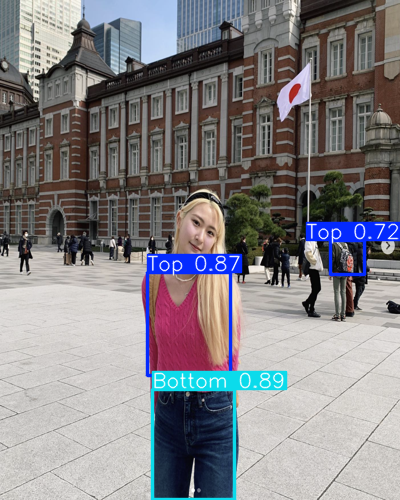

----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
실제 착용 하의 R G B 
(166, 92, 100)


예측한 하의 R G B
(90.9, 97.2, 98.5)


----------------------------------------------------------------------------------------------------


In [3]:
image_path = "/data1/project/seoeun/BAF/test4.png"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    
    print('하의 추출 결과 입니다')
    show_color(bottom_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()
print('-'*100)
print('\n\n\n\n')


# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])


# 결과 시각화 - 실제 하의 색상 시각화
truth_bottom_RGB = tuple(map(lambda x: round(x, 2), result_dataframe['BOTTOM_RGB'].values[0]))
print('-'*100)
print('실제 착용 하의 R G B ')
print(truth_bottom_RGB)
show_color(truth_bottom_RGB)


# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
         TOP_RGB BOTTOM_RGB
0  (135, 95, 91)        NaN


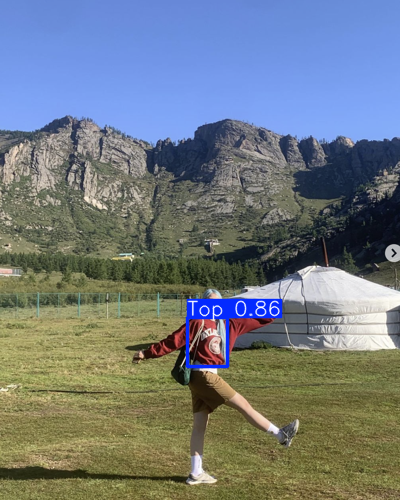






----------------------------------------------------------------------------------------------------
예측한 하의 R G B
(74.8, 71.4, 67.9)


----------------------------------------------------------------------------------------------------


In [4]:
image_path = "/data1/project/seoeun/BAF/test5.png"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()





# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])



# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('\n\n\n\n')
print('-'*100)
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)



Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


하의 추출 결과 입니다


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
        TOP_RGB       BOTTOM_RGB
0  (38, 37, 32)  (146, 140, 127)


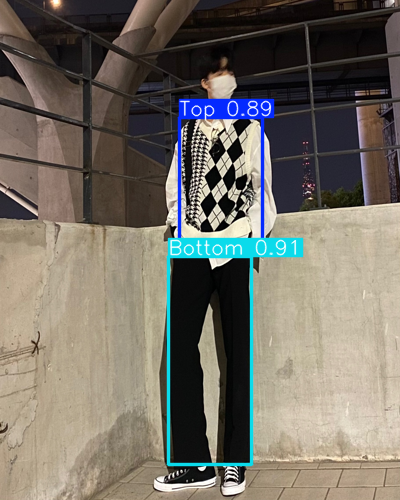

----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
실제 착용 하의 R G B 
(146, 140, 127)


예측한 하의 R G B
(48.2, 52.7, 46.4)


----------------------------------------------------------------------------------------------------


In [5]:
image_path = "/data1/project/seoeun/BAF/test8.jpg"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    
    print('하의 추출 결과 입니다')
    show_color(bottom_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()
print('-'*100)
print('\n\n\n\n')


# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])


# 결과 시각화 - 실제 하의 색상 시각화
truth_bottom_RGB = tuple(map(lambda x: round(x, 2), result_dataframe['BOTTOM_RGB'].values[0]))
print('-'*100)
print('실제 착용 하의 R G B ')
print(truth_bottom_RGB)
show_color(truth_bottom_RGB)


# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 


YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
           TOP_RGB BOTTOM_RGB
0  (136, 129, 122)        NaN


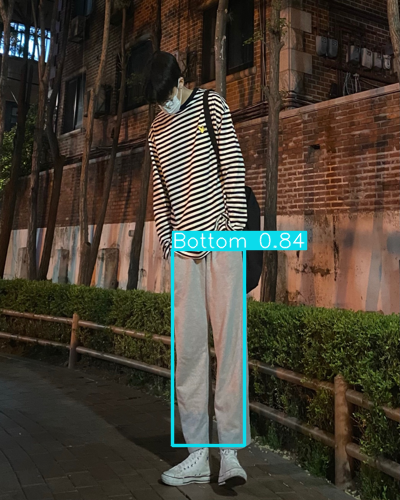






----------------------------------------------------------------------------------------------------
예측한 하의 R G B
(80.2, 86.4, 96.1)


----------------------------------------------------------------------------------------------------


In [6]:
image_path = "/data1/project/seoeun/BAF/test7.jpg"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()

# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])



# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('\n\n\n\n')
print('-'*100)
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
        TOP_RGB    BOTTOM_RGB
0  (48, 62, 85)  (44, 54, 71)


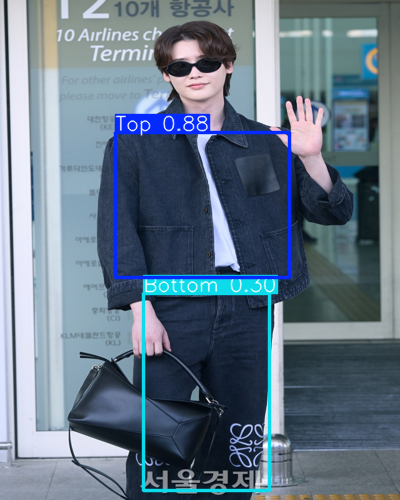






----------------------------------------------------------------------------------------------------
예측한 하의 R G B
(73.2, 90.2, 104.2)


----------------------------------------------------------------------------------------------------


In [7]:
image_path = "/data1/project/seoeun/BAF/test9.jpg"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()

# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])



# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('\n\n\n\n')
print('-'*100)
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)


Using cache found in /home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-26 Python-3.9.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/home/hemoa001/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


----------------------------------------------------------------------------------------------------
상의 추출 결과 입니다


----------------------------------------------------------------------------------------------------





----------------------------------------------------------------------------------------------------
          TOP_RGB    BOTTOM_RGB
0  (86, 156, 183)  (12, 27, 51)


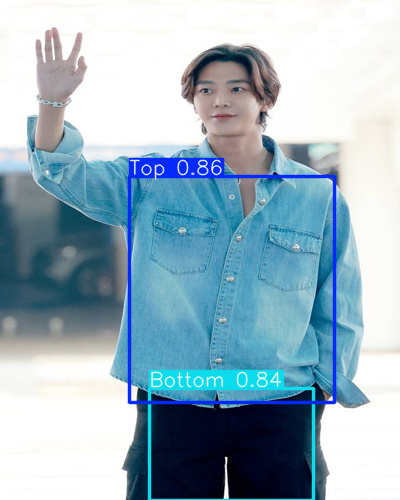






----------------------------------------------------------------------------------------------------
예측한 하의 R G B
(65.5, 81.4, 89.7)


----------------------------------------------------------------------------------------------------


In [8]:
image_path = "/data1/project/seoeun/BAF/test10.jpg"
model_path = "/data1/project/seoeun/BAF/yolov5/runs/train/best_yolov5s_result3/weights/best.pt"

result_dataframe, results_resized = extract_major_colors(image_path, model_path)

# 상의와 하의 색상 출력
for idx, row in result_dataframe.iterrows():
    top_rgb = row['TOP_RGB']
    bottom_rgb = row['BOTTOM_RGB']
    
    print('-'*100)
    print('상의 추출 결과 입니다')
    show_color(top_rgb)
    print('-'*100)
    print('\n\n\n\n')

print('-'*100)
print(result_dataframe)
results_resized.show()

# 데이터 준비
X_top = convert_to_numeric(result_dataframe['TOP_RGB'].tolist())
X_bottom = convert_to_numeric(result_dataframe['BOTTOM_RGB'].tolist())

# 상의의 색상을 기반으로 하의의 색상 예측
predicted_bottom = KNN_model.predict(X_top.reshape(1, -1))

# 정규화된 예측된 하의 색상을 원래의 RGB 형태로 변환
predicted_bottom_RGB = convert_to_original(predicted_bottom[0])



# 결과 시각화 - 예측된 하의 색상 시각화
predicted_bottom_RGB_rounded = tuple(map(lambda x: round(x, 2), predicted_bottom_RGB))
print('\n\n\n\n')
print('-'*100)
print('예측한 하의 R G B')
print(predicted_bottom_RGB_rounded)
show_color(predicted_bottom_RGB_rounded)
print('-'*100)
